# Understanding the relationship between COVID-19 and Opioid overdose deaths in the US

Import statements and data you need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm #this line is now always in our opener
import scipy.stats as stats
from patsy import dmatrices
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

## Data Cleaning

Data to be cleaned:
1. Census race data
2. Unemployment data
3. State COVID-19 data
4. Drug Overdose/Opioid Overdose death data

### Census Race Data

Clean up column headers by changing them to the first row entries, which are more descriptive, and removing "!!" from those entries for legibility.

In [2]:
# dataframe for first csv

# Path to the data - select the path that works for you 
file_path = '../data-mining-semester-project/data/Census race.csv'

# Load the data into a DataFrame 
dfCensus = pd.read_csv(file_path)

dfCensus = dfCensus.dropna()
dfCensus= dfCensus.replace('!!',' ', regex=True)

# replace column headers with first row (more useful imo)
header = dfCensus.iloc[0]
dfCensus = dfCensus[1:]
dfCensus = dfCensus.rename(columns = header)

dfCensus.head()

,id,Geographic Area Name,Total:,Total: Population of one race:,Total: Population of one race: White alone,Total: Population of one race: Black or African American alone,Total: Population of one race: American Indian and Alaska Native alone,Total: Population of one race: Asian alone,Total: Population of one race: Native Hawaiian and Other Pacific Islander alone,Total: Population of one race: Some Other Race alone,...,Total: Population of two or more races: Population of four races: American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races:,Total: Population of two or more races: Population of five races: White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander,Total: Population of two or more races: Population of five races: White; Black or African American; American Indian and Alaska Native; Asian; Some Other Race,Total: Population of two or more races: Population of five races: White; Black or African American; American Indian and Alaska Native; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races: White; Black or African American; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races: White; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of five races: Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race,Total: Population of two or more races: Population of six races:,Total: Population of two or more races: Population of six races: White; Black or African American; American Indian and Alaska Native; Asian; Native Hawaiian and Other Pacific Islander; Some Other Race
1,0500000US01001,"Autauga County, Alabama",58805,55648,42160,11445,217,881,35,910,...,0,2,2,0,0,0,0,0,0,0
2,0500000US01003,"Baldwin County, Alabama",231767,216743,189399,18217,1582,2067,143,5335,...,0,0,0,0,0,0,0,0,0,0
3,0500000US01005,"Barbour County, Alabama",25223,24523,11317,11933,116,117,1,1039,...,0,2,2,0,0,0,0,0,0,0
4,0500000US01007,"Bibb County, Alabama",22293,21534,16555,4413,60,32,9,465,...,0,0,0,0,0,0,0,0,0,0
5,0500000US01009,"Blount County, Alabama",59134,55478,50663,845,337,178,24,3431,...,0,1,0,0,1,0,0,0,0,0


### Unemployment Data

Remove all non-2020 columns and remove commas in data. Data type is changed to int later when nan values are removed.

In [3]:
# dataframe for second csv file 
file_path2 = '../data-mining-semester-project/data/Unemployment.csv'

# Load the data into a DataFrame 
dfUnemployment = pd.read_csv(file_path2)
dfUnemployment_all = dfUnemployment.copy()

# getting rid of values outside of 2020
dfUnemployment = dfUnemployment.iloc[:,[1,2,86,87,88,89]]

dfUnemployment['Civilian_labor_force_2020'] = dfUnemployment['Civilian_labor_force_2020'].str.replace(',', '')
dfUnemployment['Employed_2020'] = dfUnemployment['Employed_2020'].str.replace(',', '')
dfUnemployment['Unemployed_2020'] = dfUnemployment['Unemployed_2020'].str.replace(',', '')
dfUnemployment = dfUnemployment.drop(["State"],axis=1).copy()

dfUnemployment.head()

,Area_name,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020
0,United States,160611064,147677360,12933704,8.1
1,Alabama,2230118,2099062,131056,5.9
2,"Autauga County, AL",25838,24576,1262,4.9
3,"Baldwin County, AL",96763,91338,5425,5.6
4,"Barbour County, AL",8587,7982,605,7.0


### State COVID-19 Data

Filter out all but 2020 data and format.

In [5]:
# state death data covid19
file_path5 = '../data-mining-semester-project/data/statesCOVID.csv'

dfStateC19Death = pd.read_csv(file_path5)
dfStateC19Death.head()

dfStateC19Death = dfStateC19Death[(dfStateC19Death['date'] >= '2020-01-01') & (dfStateC19Death['date'] <= '2020-12-31')]
dfStateC19Death['date'] = pd.to_datetime(dfStateC19Death['date'])
dfStateC19Death.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


### Drug Overdose/Opioid Death Data

Remove other unnecessary columns. Change the year and month columns to a singluar date column for easier plotting. Filter out all except Opioid overdose deaths. Filter out "US" as a state (not being used). Turn "Data Value" columns into floats ("Data Value" columns is the number of OD deaths).

The last block of code filters out dates from 2018-2020 and aggregates data for all the states by month to be plotted in a time plot.

In [7]:
# death data for type of drug 
# VSRR_Provisional_Drug_Overdose_Death_Counts.csv
file_path3 = '../data-mining-semester-project/data/VSRR_Provisional_Drug_Overdose_Death_Counts-3.csv'

# drop anything not in a southern state to start, retain data from 2015 to end of 2020

# Load the data into a DataFrame 
dfTypeDrug = pd.read_csv(file_path3)
dfTypeDrug = dfTypeDrug.drop(["Period"],axis=1)
dfTypeDrug = dfTypeDrug.drop(["Footnote"],axis=1)
dfTypeDrug = dfTypeDrug.drop(["Footnote Symbol"],axis=1)

dfODeath = dfTypeDrug.copy() 

# changing Month and Year columns to "date" column for easier plotting
dfTypeDrug['Date'] = dfTypeDrug['Month'].map(str)+ '-' +dfTypeDrug['Year'].map(str)
dfTypeDrug['Date'] = pd.to_datetime(dfTypeDrug['Date'])
dfTypeDrug = dfTypeDrug.drop(["Year"],axis=1)
dfTypeDrug = dfTypeDrug.drop(["Month"],axis=1)

# for now, just using "Opioids (T40.0-T40.4,T40.6)" as the data 
dfTypeDrug = dfTypeDrug[(dfTypeDrug['Indicator'] == "Opioids (T40.0-T40.4,T40.6)")]

# remove the whole US category
dfTypeDrug = dfTypeDrug[(dfTypeDrug['State'] != "US")]

dfTypeDrug['Data Value'] = dfTypeDrug['Data Value'].str.replace(',', '')
dfTypeDrug = dfTypeDrug.astype({'Data Value': float}) 

df_18_20_Opioid = dfTypeDrug[(dfTypeDrug['Date'] >= '2018-01-01') & (dfTypeDrug['Date'] <= '2020-12-31')].copy()
df_18_20_Opioid['Total Deaths per Month'] = df_18_20_Opioid.groupby([pd.Grouper(key='Date', freq='1M')])['Data Value'].transform('sum')
df_18_20_Opioid = df_18_20_Opioid[['Date', 'Total Deaths per Month']]
df_18_20_Opioid = df_18_20_Opioid.drop_duplicates()
df_18_20_Opioid = df_18_20_Opioid.sort_values('Date')
df_18_20_Opioid.head()

,Date,Total Deaths per Month
491,2018-01-01,27722.0
478,2018-02-01,29541.0
526,2018-03-01,29689.0
437,2018-04-01,28506.0
528,2018-05-01,28385.0


## 2020 State Data

The next several dataframes are all data cleaning and aggregation to have a set of 2020-by-state data points

### Opioid 2020 State Data

In the opioid dataset, pd.Grouper was used to obtain a total death count by state. However, some states did not have data for all 12 months. To fill in the data, the mean death by month for those states was used. 

In [8]:
# opioid data
# some missing data, used mean to make predictions on what that data may have been

# filter out dates and unnecessary columns
dfOpioid2020 = dfTypeDrug[(dfTypeDrug['Date'] >= '2020-01-01') & (dfTypeDrug['Date'] <= '2020-12-31')]
dfOpioid2020 = dfOpioid2020[['State Name', 'Date', 'Data Value']]
dfOpioid2020 = dfOpioid2020.sort_values('State Name')

# gather the mean 
dfOpioid2020['Avg Deaths'] = (dfOpioid2020.groupby([pd.Grouper(key='State Name')])['Data Value'].transform('mean'))
AvgDeaths = dfOpioid2020['Avg Deaths'].to_numpy()
NewTotalDeaths = np.array(AvgDeaths * 12)
NewTotalDeaths = pd.DataFrame(NewTotalDeaths)
dfOpioid2020.insert(2, "Total Opioid Deaths 2020", NewTotalDeaths)

dfOpioid2020byMonth = dfOpioid2020.copy()
dfOpioid2020 = dfOpioid2020.iloc[:,[0,2]]
dfOpioid2020 = dfOpioid2020.drop_duplicates()
dfOpioid2020byMonth = dfOpioid2020byMonth.iloc[:,[0,1,3]]
dfOpioid2020.head()
# dfOpioid2020byMonth

,State Name,Total Opioid Deaths 2020
721,Alaska,1035.0
2157,Arizona,20167.0
3057,California,54222.0
4005,Colorado,10130.0
4891,Connecticut,14577.0


### COVID-19 2020 State Data

For this dataframe, the totals by month by state were summed using pd.Grouper for both cases and deaths. This data was formatted in a manner that was conducive to the aggregation by state, so not much needed to be done.

In [9]:
# COVID data
# filter out states we don't care about
# filter just 2020 timeframe
dfCOVID2020 = dfStateC19Death.copy()
dfCOVID2020 = dfCOVID2020.drop(["fips"],axis=1)

# total by month for each state
dfCOVID2020 = dfCOVID2020.sort_values('date')
dfCOVID2020 = dfCOVID2020.sort_values('state')

dfCOVID2020['Total COVID Cases 2020'] = (dfCOVID2020.groupby([pd.Grouper(key='state')])['cases'].transform('max'))
dfCOVID2020['Total COVID Deaths 2020'] = (dfCOVID2020.groupby([pd.Grouper(key='state')])['deaths'].transform('max'))
dfCOVID2020 = dfCOVID2020.iloc[:,[1,4,5]]
dfCOVID2020 = dfCOVID2020.drop_duplicates()
dfCOVID2020.head()

,state,Total COVID Cases 2020,Total COVID Deaths 2020
12609,Alabama,361226,4827
1720,Alaska,46740,198
14261,Arizona,523829,8879
12887,Arkansas,225138,3676
1448,California,2307860,25965


### Removing States with No Data

For now, all states without any COVID or opioid data are being removed for the sake of comparison between states. This includes: Alabama, Arkansas, Florida, Idaho, Louisiana, Minnesota, North Dakota, Nebraska, Pennsylvania for the opioid dataset. The cities, states, or territories that are simply not being analyzed in this research are also removed, including: American Samoa, Guam, Northern Mariana Islands, Virgin Islands, Puerto Rico, New York City, and the full US totals.

All states with available data are put into their own list for easy access on the following data cleaning blocks.

In [10]:
# drop the states we don't have data for (at least for now)
# Alabama, Arkansas, Florida, Idaho, Louisiana, Minnesota, North Dakota, Nebraska, Pennsylvania
# as well as drop American Samoa, Guam, Northern Mariana Islands, Virgin Islands, and Puerto Rico
# and NYC for opioid set


dfCOVID2020 = dfCOVID2020[(dfCOVID2020['state'] != "American Samoa") &
                          (dfCOVID2020['state'] != "Guam") &
                          (dfCOVID2020['state'] != "Northern Mariana Islands") &
                          (dfCOVID2020['state'] != "Virgin Islands") & 
                          (dfCOVID2020['state'] != "Puerto Rico")]

dfCOVID2020_states = dfCOVID2020.copy()

dfCOVID2020 = dfCOVID2020[(dfCOVID2020['state'] != "Alabama") &
                          (dfCOVID2020['state'] != "Arkansas") &
                          (dfCOVID2020['state'] != "Florida") &
                          (dfCOVID2020['state'] != "Idaho") &
                          (dfCOVID2020['state'] != "Louisiana") &
                          (dfCOVID2020['state'] != "Minnesota") &
                          (dfCOVID2020['state'] != "North Dakota") &
                          (dfCOVID2020['state'] != "Nebraska") &
                          (dfCOVID2020['state'] != "Pennsylvania")]

dfOpioid2020 = dfOpioid2020[(dfOpioid2020['State Name'] != "New York City")]
dfOpioid2020byMonth = dfOpioid2020byMonth[(dfOpioid2020byMonth['State Name'] != "New York City")]

stateswithavailabledata = dfCOVID2020['state'].unique()

### COVID 2020 Data by Month

This data was strictly to get the totals of COVID 2020 data by month.

In [11]:
# work on this df as a copy of the original df
dfCOVID2020byMonth = dfStateC19Death.copy()
dfCOVID2020byMonth = dfCOVID2020byMonth.drop(["fips"],axis=1)

# filter only states with data
dflist = []
for x in stateswithavailabledata:
    dflist.append(dfCOVID2020byMonth[(dfCOVID2020byMonth['state'] == x)].copy())

temp = pd.DataFrame()

# aggregate the total number of cases/deaths per month for each state
# since the totals are cumulative, max was used for pd.Grouper()
# each state is its own individual df at this point for the sake of aggregation,
# so it needs to be appended back together
for x in dflist:
    x['Monthly COVID Cases 2020'] = (x.groupby([pd.Grouper(key='date', freq='1M')])['cases'].transform('max'))
    x['Monthly COVID Deaths 2020'] = (x.groupby([pd.Grouper(key='date', freq='1M')])['deaths'].transform('max'))
    temp = temp.append(x)

# no longer working with the cases and deaths on each day, so remove those
dfCOVID2020byMonth = temp
dfCOVID2020byMonth = dfCOVID2020byMonth.drop(["cases"],axis=1)
dfCOVID2020byMonth = dfCOVID2020byMonth.drop(["deaths"],axis=1)

# change the m/d/y format to just the month and remove duplicates
dfCOVID2020byMonth['date'] = dfCOVID2020byMonth['date'].dt.month
dfCOVID2020byMonth = dfCOVID2020byMonth.drop_duplicates()
dfCOVID2020byMonth = dfCOVID2020byMonth.astype({'date': int})

# change everthing to a numpy array to iterate through and extract the monthly total 
# instead of the cumulative total
# i.e. December monthly total = cumulative December total - cumulative November total
datearray = dfCOVID2020byMonth['date'].to_numpy()
statearray = dfCOVID2020byMonth['state'].to_numpy()
casesarray = dfCOVID2020byMonth['Monthly COVID Cases 2020'].to_numpy()
deatharray = dfCOVID2020byMonth['Monthly COVID Deaths 2020'].to_numpy()
        
for i in range(len(datearray)):
    idx = len(datearray)-1-i
    if ((datearray[idx] > 1) & (statearray[idx] == statearray[idx-1])):
        deatharray[idx] -= deatharray[idx-1]
        casesarray[idx] -= casesarray[idx-1]

# fill in df if the state does not have data for a month (likely January/February/March)
# this solution is computationally pretty inefficient, 
# however the dataset is small enough for any inefficiencies to be negligible
dates = dfCOVID2020byMonth['date'].unique()
dates = np.sort(dates)

dflist = []
for x in stateswithavailabledata:
    dflist.append(dfCOVID2020byMonth[(dfCOVID2020byMonth['state'] == x)].copy())

emptyrows = []
    
for x in dflist:
    x_datearray = x['date'].to_numpy()
    x_statearray = x['state'].to_numpy()
    for i, date in enumerate(dates):
        if(date not in x_datearray):
            emptyrows.append([date, x_statearray[i], 0, 0])

emptyrows = pd.DataFrame(emptyrows)
emptyrows = emptyrows.rename(columns = {0:"date", 1:"state", 2:"Monthly COVID Cases 2020", 3:"Monthly COVID Deaths 2020"})
dfCOVID2020byMonth = dfCOVID2020byMonth.append(emptyrows, ignore_index = True)
dfCOVID2020byMonth = dfCOVID2020byMonth.sort_values('state')
dfCOVID2020byMonth = dfCOVID2020byMonth.astype({'date': str})
datearray = dfCOVID2020byMonth['date'].to_numpy()
for i, x in enumerate(datearray):
    x = x.replace(x, x + '-01-2020')
    datearray[i] = x

dfCOVID2020byMonth['date'] = pd.to_datetime(dfCOVID2020byMonth['date'])
dfCOVID2020byMonth

dfCOVIDbyMonth = dfCOVID2020byMonth.copy()
dfCOVIDbyMonth['Total Monthly COVID Cases'] = dfCOVIDbyMonth.groupby([pd.Grouper(key='date', freq='1M')])['Monthly COVID Cases 2020'].transform('sum')
dfCOVIDbyMonth['Total Monthly COVID Deaths'] = dfCOVIDbyMonth.groupby([pd.Grouper(key='date', freq='1M')])['Monthly COVID Deaths 2020'].transform('sum')
dfCOVIDbyMonth = dfCOVIDbyMonth[['date','Total Monthly COVID Cases', 'Total Monthly COVID Deaths']]
dfCOVIDbyMonth = dfCOVIDbyMonth.drop_duplicates()
dfCOVIDbyMonth = dfCOVIDbyMonth.sort_values('date')
dfCOVIDbyMonth.head()

,date,Total Monthly COVID Cases,Total Monthly COVID Deaths
433,2020-01-01,7,0
434,2020-02-01,50,1
0,2020-03-01,167975,3846
1,2020-04-01,772141,52609
2,2020-05-01,612122,34840


### Opioid 2020 State Data by Month

This data was to get the totals of Opioid 2020 data by state by month, to plot against COVID data over time.

In [12]:
# filter out states
dfOpioid2020byMonth['Average Deaths'] = dfOpioid2020byMonth.groupby([pd.Grouper(key='State Name')])['Data Value'].transform('mean')
dflist = []
for x in stateswithavailabledata:
    dflist.append(dfOpioid2020byMonth[(dfOpioid2020byMonth['State Name'] == x)].copy())
    
emptyrows = []
    
# fill in empty rows with the average
for x in dflist:
    x_datearray = x['Date'].to_numpy(dtype='datetime64[D]')
    x_statearray = x['State Name'].to_numpy()
    x_data = x['Data Value'].to_numpy()
    x_avgdata = x['Average Deaths'].to_numpy()
    for i, data in enumerate(x_data):
        if np.isnan(x_data[i]):
            emptyrows.append([x_statearray[i], x_datearray[i], x_avgdata[i], x_avgdata[i]])

# convert empty rows to their own df and append them
emptyrows = pd.DataFrame(emptyrows)
emptyrows = emptyrows.rename(columns = {0:"State Name", 1:"Date", 2:"Data Value", 3:"Average Deaths"})

dfOpioid2020byMonth = dfOpioid2020byMonth.append(emptyrows, ignore_index = True)
dfOpioid2020byMonth = dfOpioid2020byMonth.sort_values('State Name')
dfOpioid2020byMonth = dfOpioid2020byMonth.dropna()
dfOpioid2020byMonth = dfOpioid2020byMonth.astype({'Date': str})
dfOpioid2020byMonth['Date'] = pd.to_datetime(dfOpioid2020byMonth['Date'])
dfOpioid2020byMonth.head()

,State Name,Date,Data Value,Average Deaths
0,Alaska,2020-04-01,74.0,86.25
11,Alaska,2020-07-01,93.0,86.25
10,Alaska,2020-08-01,98.0,86.25
9,Alaska,2020-12-01,102.0,86.25
7,Alaska,2020-01-01,80.0,86.25


## Clustering to Predict Data for States without data

K-means clustering was used to fill in the data and make an estimate of the number of opioid overdose deaths. This was done using the state population, the number of total drug overdose deaths, and the unemployment rate attributes for 2020 only. Those attributes were used to cluster the states together into 7 clusters. From those clusters, the average proportion of opioid deaths to total drug overdose deaths was taken for each cluster. This average was then applied to the drug overdose death total for each state to make an estimate for the number of opioid overdose deaths.

In [13]:
# Missing Opioid data 2020:
# Cluster states by population, total drug od death
# Fill in by getting ratio of Opioid/Total for same cluster states
# Declare those as estimates
# columns of this df should be:
# State - Indicator - Data Value - Population

# state population
dfCensus["State"] = dfCensus["Geographic Area Name"].str.replace('(.+.+.+.+ \w+, )','',regex=True)
dfCensus["State"] = dfCensus["State"].str.replace('(.+ \w+, )','',regex=True)
dfCensus2020 = dfCensus
# i gave up on trying to make the col headers nice
dfCensus2020 = dfCensus2020.astype({'  Total:': int}) 
dfCensus2020['Total State Population'] = (dfCensus2020.groupby([pd.Grouper(key='State')])['  Total:'].transform('sum'))
dfCensus2020_pop = dfCensus2020[['State', 'Total State Population']]
dfCensus2020_pop = dfCensus2020_pop.drop_duplicates()
dfCensus2020_pop2 = dfCensus2020_pop.copy()

dfDrugCluster = dfODeath[['State Name', 'Year', 'Month', 'Indicator', 'Data Value']].copy()

# changing Month and Year columns to "date" column for easier plotting
dfDrugCluster['Date'] = dfDrugCluster['Month'].map(str)+ '-' +dfDrugCluster['Year'].map(str)
dfDrugCluster['Date'] = pd.to_datetime(dfDrugCluster['Date'])
dfDrugCluster = dfDrugCluster.drop(["Year"],axis=1)
dfDrugCluster = dfDrugCluster.drop(["Month"],axis=1)
dfDrugCluster = dfDrugCluster.sort_values('State Name')
dfDrugCluster = dfDrugCluster[(dfDrugCluster['Date'] >= '2020-01-01') & (dfDrugCluster['Date'] <= '2020-12-31')]
dfDrugCluster = dfDrugCluster[(dfDrugCluster['Indicator'] == "Opioids (T40.0-T40.4,T40.6)") + (dfDrugCluster['Indicator'] == "Number of Drug Overdose Deaths")]
dfDrugCluster['Data Value'] = dfDrugCluster['Data Value'].str.replace(',', '')
dfDrugCluster = dfDrugCluster.astype({'Data Value': float}) 

dflist = []
for x in dfDrugCluster['State Name'].unique():
    dflist.append(dfDrugCluster[(dfDrugCluster['State Name'] == x)].copy())

temp = pd.DataFrame()
    
for x in dflist:
    x['Total Deaths'] = (x.groupby([pd.Grouper(key='Indicator')])['Data Value'].transform('sum'))
    temp = temp.append(x)

dfDrugCluster = temp.drop(["Date"],axis=1)
dfDrugCluster = dfDrugCluster.drop(["Data Value"],axis=1)
dfDrugCluster = dfDrugCluster.drop_duplicates()
dfDrugCluster2 = dfDrugCluster[(dfDrugCluster['Indicator'] == "Number of Drug Overdose Deaths")]
dfDrugCluster2 = dfDrugCluster2[(dfDrugCluster2['State Name'] != "United States") & (dfDrugCluster2['State Name'] != "New York City")]

dflist = []
for x in dfDrugCluster2['State Name'].unique():
    dflist.append(dfUnemployment[(dfUnemployment['Area_name'] == x)])

dfDrugCluster2 = dfDrugCluster2.set_index('State Name')
dfCensus2020_pop2 = dfCensus2020_pop2[(dfCensus2020_pop2['State'] != "Puerto Rico")]
rows = dfCensus2020_pop2['State'].unique()
dfCensus2020_pop3 = dfCensus2020_pop2.set_index('State')
dfDrugCluster2 = dfDrugCluster2.drop(["Indicator"],axis=1)

dfUnemploymentCluster = pd.DataFrame()

for x in dflist:
    dfUnemploymentCluster = dfUnemploymentCluster.append(x)

dfUnemploymentCluster = dfUnemploymentCluster.drop_duplicates()
dfUnemploymentCluster.head()


a1 = dfDrugCluster2['Total Deaths'].to_numpy()
a2 = dfCensus2020_pop3['Total State Population'].to_numpy()
a3 = dfUnemploymentCluster['Unemployment_rate_2020'].to_numpy()
df1 = pd.DataFrame(a1, index=rows)
df2 = pd.DataFrame(a2, index=rows)
df3 = pd.DataFrame(a3, index=rows)

cols=['Drug OD', 'Population', 'Unemployment Rate']
data=[df1, df2, df3]
dfcluster = pd.concat(data,axis=1)
dfcluster.columns = cols
dfcluster.head()

km = KMeans(
    n_clusters=7, init='random',
    n_init=10, max_iter=3000, 
    tol=1e-04, random_state=1
)
y_km = km.fit_predict(dfcluster)

dfOpioid2020_2 = dfOpioid2020.set_index('State Name').copy()

df4 = pd.DataFrame(y_km, index=rows)
df5 = pd.DataFrame(rows, index=rows)
df6 = pd.DataFrame(dfOpioid2020_2['Total Opioid Deaths 2020'], index=rows)
dfcluster = pd.concat([dfcluster,df4,df5,df6],axis=1)
cols.append('Cluster')
cols.append('State')
cols.append('Opioid OD')
dfcluster.columns = cols

# now that I have the clusters, I need the average proportion of opioid OD/drug OD deaths per cluster 
# once I have that proportion, multiply it by drug OD deaths for an estimate of opioid OD deaths on states with missing data

drugOD = dfcluster['Drug OD'].to_numpy()
opioidOD = dfcluster['Opioid OD'].to_numpy()
opioidOD_rate = np.array(opioidOD/drugOD)

df7 = pd.DataFrame(opioidOD_rate, index=rows)
dfcluster = pd.concat([dfcluster,df7],axis=1)
cols.append('Opioid OD Percentage')
dfcluster.columns = cols
dfcluster
    
dfcluster['Average Opioid OD Percentage'] = dfcluster.groupby([pd.Grouper(key='Cluster')])['Opioid OD Percentage'].transform('mean')
avgrate = dfcluster['Average Opioid OD Percentage'].to_numpy()
opioidOD_estimate = np.array(avgrate*drugOD)
opioidOD_estimate = np.round(opioidOD_estimate)
opioidOD_estimate = opioidOD_estimate.astype(int)

df8 = pd.DataFrame(opioidOD_estimate, index=rows)
dfcluster = pd.concat([dfcluster,df8],axis=1)
cols.append('Average Opioid OD Percentage')
cols.append('Opioid OD Estimate')
dfcluster.columns = cols
values = {'Opioid OD': dfcluster['Opioid OD Estimate']}
dfcluster = dfcluster.fillna(value=values)

# okay so this part was to determine the number of clusters I should use
# I was gonna make the whole clustering code and df manipulation a function 
# and the grab the n_clusters with min(percenterrornoNA)
# but it was easier to find an answer manually by changing n_clusters a bunch
# 7 clusters had the least error

percenterror = ((opioidOD-opioidOD_estimate)/opioidOD)*100
percenterrornoNA = percenterror[np.logical_not(np.isnan(percenterror))]
print("Avg % error =", np.average(percenterrornoNA))

dfcluster.head()

Avg % error = -5.91078975434998


,Drug OD,Population,Unemployment Rate,Cluster,State,Opioid OD,Opioid OD Percentage,Average Opioid OD Percentage,Opioid OD Estimate
Alabama,10624.0,5024279,5.9,5,Alabama,8142.0,NaN,0.766423,8142
Alaska,1591.0,733391,7.8,2,Alaska,1035.0,0.650534,0.730834,1163
Arizona,28466.0,7151502,7.9,5,Arizona,20167.0,0.708459,0.766423,21817
Arkansas,5325.0,3011524,6.1,4,Arkansas,3341.0,NaN,0.627499,3341
California,92810.0,39538223,10.1,6,California,54222.0,0.584226,0.531440,49323


### Census 2020 State Race Data

This data was cleaned to get the breakdown of different races by state for 2020. There were several categories for mixed races in the original dataset that brought it to 73 total columns. To reduce that, mixed races are all a part of the "Total: Population of two or more races:" attribute.

In [14]:
# Census Race Data
# get all the columns by state

# i'm breaking this up into each single race and then two+ as just one category (too many combinations when you get to 3+ races)
dfCensusbyState = dfCensus.iloc[:,2:11]
# here's the state column from earlier when I got the total population of each state
dfCensusbyState.insert(loc=0, column='State', value=dfCensus.iloc[:,-1])
censusbystatecols = list(dfCensusbyState.columns.values)

for x in censusbystatecols:
    if x != 'State':
        dfCensusbyState = dfCensusbyState.astype({x: int}) 
        dfCensusbyState[x] = (dfCensusbyState.groupby([pd.Grouper(key='State')])[x].transform('sum'))

dfCensusbyState = dfCensusbyState.drop_duplicates()
dfCensusbyState = dfCensusbyState[(dfCensusbyState['State'] != "Puerto Rico")]
dfCensusbyState = dfCensusbyState.set_index('State')
dfCensusbyState.head()

,Total:,Total: Population of one race:,Total: Population of one race: White alone,Total: Population of one race: Black or African American alone,Total: Population of one race: American Indian and Alaska Native alone,Total: Population of one race: Asian alone,Total: Population of one race: Native Hawaiian and Other Pacific Islander alone,Total: Population of one race: Some Other Race alone,Total: Population of two or more races:
State,,,,,,,,,
Alabama,5024279,4767326,3220452,1296162,33625,76660,2984,137443,256953
Alaska,733391,643867,435392,21898,111575,44032,12698,18272,89524
Arizona,7151502,6154696,4322337,339150,319512,257430,16397,899870,996806
Arkansas,3011524,2797949,2114512,453783,27177,51839,14533,136105,213575
California,39538223,33777988,16296122,2237044,631016,6085947,157263,8370596,5760235


In [15]:
# get all the important attributes together in one place
# this includes:
# Opioid OD (fill in na with estimates) - COVID Deaths - COVID Cases - 
# Opioid per capita - COVID-D per capita - COVID-C per capita
# Civilian_labor_force_2020 - Employed_2020 - Unemployed_2020 - Unemployment_rate_2020
# All census race/total data 

# dfs required:
# dfcluster
# dfpercapita
# dfUnemployment_all
# dfCensusbyState

# make per capita for opioid and covid with all states
# get COVID totals all states
# append all of the last 2 df
# remove "Total: Population of one race:" and "Total:"

populations = dfcluster['Population'].to_numpy()
covidcases = dfCOVID2020_states['Total COVID Cases 2020'].to_numpy()
coviddeaths = dfCOVID2020_states['Total COVID Deaths 2020'].to_numpy()
opioiddeaths = dfcluster['Opioid OD'].to_numpy()
covidcasespercapita = np.array(covidcases/populations)
coviddeathspercapita = np.array(coviddeaths/populations)
opioiddeathspercapita = np.array(opioiddeaths/populations)

df1 = pd.DataFrame(opioiddeaths, index=rows)
df2 = pd.DataFrame(covidcases, index=rows)
df3 = pd.DataFrame(coviddeaths, index=rows)
df4 = pd.DataFrame(opioiddeathspercapita, index=rows)
df5 = pd.DataFrame(covidcasespercapita, index=rows)
df6 = pd.DataFrame(coviddeathspercapita, index=rows)
df7 = pd.DataFrame(populations, index=rows)

cols=['Opioid Deaths', 'COVID Cases', 'COVID Deaths', 'Opioid Deaths Per Capita', 'COVID Cases Per Capita', 'COVID Deaths Per Capita', 'Population']
data=[df1, df2, df3, df4, df5, df6, df7]
df_analysis = pd.concat(data,axis=1)
df_analysis.columns = cols
df_analysis.head()

dflist = []
for x in rows:
    dflist.append(dfUnemployment[(dfUnemployment['Area_name'] == x)])
    
dfUnemployment2020_all = pd.DataFrame()

for x in dflist:
    dfUnemployment2020_all = dfUnemployment2020_all.append(x)

dfUnemployment2020_all = dfUnemployment2020_all.drop_duplicates()
dfUnemployment2020_all = dfUnemployment2020_all.set_index('Area_name')
dfUnemployment2020_all = dfUnemployment2020_all.astype({'Civilian_labor_force_2020': int, 'Employed_2020': int, 'Unemployed_2020': int})


dfCensusbyState_temp = dfCensusbyState.copy()
dfCensusbyState_temp = dfCensusbyState_temp.drop(['  Total:'],axis=1)
dfCensusbyState_temp = dfCensusbyState_temp.drop(['  Total: Population of one race:'],axis=1)
dfCensusbyState_temp

df_analysis = pd.concat([df_analysis, dfUnemployment2020_all, dfCensusbyState_temp],axis=1)
df_analysis.corr()

,Opioid Deaths,COVID Cases,COVID Deaths,Opioid Deaths Per Capita,COVID Cases Per Capita,COVID Deaths Per Capita,Population,Civilian_labor_force_2020,Employed_2020,Unemployed_2020,Unemployment_rate_2020,Total: Population of one race: White alone,Total: Population of one race: Black or African American alone,Total: Population of one race: American Indian and Alaska Native alone,Total: Population of one race: Asian alone,Total: Population of one race: Native Hawaiian and Other Pacific Islander alone,Total: Population of one race: Some Other Race alone,Total: Population of two or more races:
Opioid Deaths,1.000000,0.758506,0.728414,0.312074,-0.138598,0.174537,0.776217,0.778711,0.778848,0.763327,0.384841,0.844409,0.697328,0.356171,0.539306,0.185602,0.545458,0.646034
COVID Cases,0.758506,1.000000,0.849197,-0.098995,0.035268,0.115246,0.981037,0.980550,0.981068,0.957845,0.296948,0.947694,0.774066,0.696176,0.815738,0.415472,0.884472,0.939418
COVID Deaths,0.728414,0.849197,1.000000,-0.028108,-0.065041,0.404515,0.875312,0.870559,0.869224,0.867714,0.428610,0.886919,0.811173,0.481317,0.666851,0.204837,0.698923,0.770004
Opioid Deaths Per Capita,0.312074,-0.098995,-0.028108,1.000000,-0.315757,0.125854,-0.078949,-0.075805,-0.077131,-0.061644,0.243396,-0.026254,0.002601,-0.251638,-0.133928,-0.288556,-0.141239,-0.133770
COVID Cases Per Capita,-0.138598,0.035268,-0.065041,-0.315757,1.000000,0.448688,-0.096598,-0.097615,-0.095577,-0.115516,-0.343767,-0.087536,-0.105893,0.060223,-0.129973,-0.273536,-0.062070,-0.081156
COVID Deaths Per Capita,0.174537,0.115246,0.404515,0.125854,0.448688,1.000000,0.088364,0.085153,0.081997,0.114060,0.221363,0.114630,0.215198,-0.065449,0.009546,-0.341713,0.019142,0.007563
Population,0.776217,0.981037,0.875312,-0.078949,-0.096598,0.088364,1.000000,0.999236,0.998896,0.984458,0.348288,0.964755,0.795489,0.691004,0.851874,0.451396,0.897796,0.945252
Civilian_labor_force_2020,0.778711,0.980550,0.870559,-0.075805,-0.097615,0.085153,0.999236,1.000000,0.999825,0.983620,0.344704,0.966725,0.787468,0.689727,0.850386,0.449931,0.895987,0.944096
Employed_2020,0.778848,0.981068,0.869224,-0.077131,-0.095577,0.081997,0.998896,0.999825,1.000000,0.980080,0.335080,0.968361,0.792663,0.685602,0.842747,0.443462,0.890976,0.944496
Unemployed_2020,0.763327,0.957845,0.867714,-0.061644,-0.115516,0.114060,0.984458,0.983620,0.980080,1.000000,0.431328,0.933483,0.723117,0.717061,0.908720,0.504217,0.928146,0.923184


# Plotting and basic analysis

There are 4 functions below for plotting and basic analysis: scatterplot, timeplot, descriptive statistics, and covidopioidplot2020. The covidopioidplot2020 is specific in that it plots the data for individual states over time.

In [16]:
def scatterplot(x_data, y_data, xlabel, ylabel):
    plt.scatter(x_data, y_data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def timeplot(x_data, y_data, xlabel, ylabel):
    plt.plot(x_data, y_data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gcf().autofmt_xdate()
    plt.show()
    
def descriptivestatistics(df, col_header):
    n = df[col_header].count()
    mean = df[col_header].mean()
    median = df[col_header].quantile(.5)
    Q1 = df[col_header].quantile(.25)
    Q3 = df[col_header].quantile(.75)
    IQR = Q3 - Q1
    stdev = df[col_header].std()
    skewness = df[col_header].skew()
    kurtosis = df[col_header].kurt()
    test_stat,p_val = stats.normaltest(df[col_header])
    # D’Agostino’s K-squared test: This tests whether a sample differs from a normal distribution.
    # H0= The sample comes from a normal distribution.
    # Ha=The sample is not coming from normal distribution.
    print(("Data for %s\nn \t= %f\nmean \t= %f\nmedian \t= %f\nQ1 \t= %f\nQ3 \t= %f\nIQR \t= %f\nstdev \t= %f\nskewness = %f\nkurtosis = %f\ntest_stat = %f\np_val = %f") 
              % (col_header, n, mean, median, Q1, Q3, IQR, stdev, skewness, kurtosis, test_stat, p_val))
    alpha = 0.05
    if p_val < alpha:
        print("Null hypothesis can be rejected. Sample comes from a non-normal distribution.\n")
    else:
        print("Null hypothesis cannot be rejected. Sample comes from a normal distribution.\n")

# scatterplot y axis death covid, x axis opioid deaths 
# manipulate the data so that the data is all binned by month and state
# average of each state each month for covid set
# df should look like:
# State - Opioid Deaths per capita - COVID Deaths per capita - Month
def covidopioidplot2020(state):
    if state in stateswithavailabledata:
        temp1 = dfCOVID2020byMonth[(dfCOVID2020byMonth['state'] == state)]
        temp2 = dfOpioid2020byMonth[(dfOpioid2020byMonth['State Name'] == state)]
        temp1 = temp1.sort_values('date')
        temp2 = temp2.sort_values('Date')        
        x_data = temp1['date']
        temp1 = temp1.set_index('date')
        temp2 = temp2.set_index('Date')
        y_data1 = temp1['Monthly COVID Deaths 2020']
        y_data2 = temp2['Data Value']
        plt.plot(x_data, y_data1, label = "COVID")
        plt.plot(x_data, y_data2, label = "Opioid")    
        plt.xlabel("Date")
        plt.ylabel("Number of Deaths")
        plt.title("COVID vs Opioid Deaths 2020 for %s" % (state))       
        plt.legend()
        plt.show()
    else:
        temp1 = dfCOVID2020byMonth.copy()
        temp2 = dfOpioid2020byMonth.copy()
        temp1['totalCD'] = (dfCOVID2020byMonth.groupby([pd.Grouper(key='date', freq='1M')])['Monthly COVID Deaths 2020'].transform('sum'))
        temp2['totalOD'] = (dfOpioid2020byMonth.groupby([pd.Grouper(key='Date', freq='1M')])['Data Value'].transform('sum'))
        temp1 = temp1[['date', 'totalCD']]
        temp2 = temp2[['Date','totalOD']]
        temp1 = temp1.sort_values('date')
        temp2 = temp2.sort_values('Date')
        temp1 = temp1.drop_duplicates()
        temp2 = temp2.drop_duplicates()
        x_data = temp1['date']
        temp1 = temp1.set_index('date')
        temp2 = temp2.set_index('Date')
        y_data1 = temp1['totalCD']
        y_data2 = temp2['totalOD']
        plt.plot(x_data, y_data1, label = "COVID")
        plt.plot(x_data, y_data2, label = "Opioid")    
        plt.xlabel("Date")
        plt.ylabel("Number of Deaths")
        plt.title("COVID vs Opioid Deaths 2020 for %s" % ("All States with Available Data"))       
        plt.legend()
        plt.show()    

In [17]:
# next step, doing respective plotting as required 

# measures of central tendency
for col in df_analysis.columns:
    descriptivestatistics(df_analysis, col)
    
# df_analysis.describe() also works but output formatting is weird and doesn't provide quite as much data

Data for Opioid Deaths
n 	= 51.000000
mean 	= 14324.901961
median 	= 10130.000000
Q1 	= 3445.000000
Q3 	= 20633.500000
IQR 	= 17188.500000
stdev 	= 15101.059586
skewness = 1.679415
kurtosis = 2.967079
test_stat = 24.226546
p_val = 0.000005
Null hypothesis can be rejected. Sample comes from a non-normal distribution.

Data for COVID Cases
n 	= 51.000000
mean 	= 390283.450980
median 	= 276834.000000
Q1 	= 106546.500000
Q3 	= 517446.500000
IQR 	= 410900.000000
stdev 	= 435018.826889
skewness = 2.622025
kurtosis = 8.367267
test_stat = 46.879019
p_val = 0.000000
Null hypothesis can be rejected. Sample comes from a non-normal distribution.

Data for COVID Deaths
n 	= 51.000000
mean 	= 6752.921569
median 	= 4787.000000
Q1 	= 1461.500000
Q3 	= 7875.500000
IQR 	= 6414.000000
stdev 	= 7952.422023
skewness = 2.078495
kurtosis = 4.515697
test_stat = 33.155576
p_val = 0.000000
Null hypothesis can be rejected. Sample comes from a non-normal distribution.

Data for Opioid Deaths Per Capita
n 	= 51.00

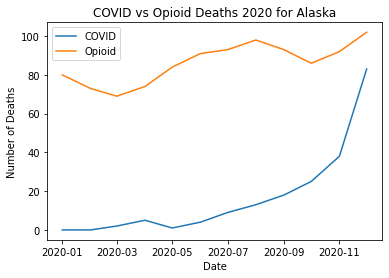

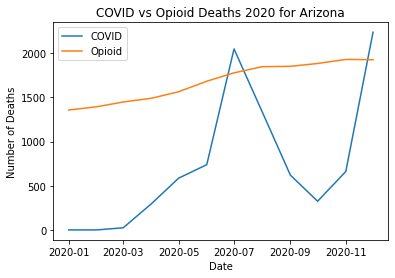

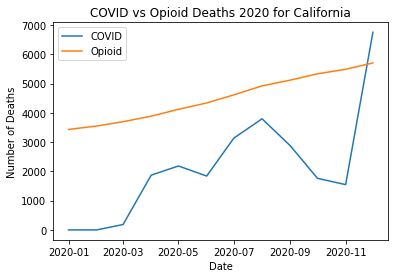

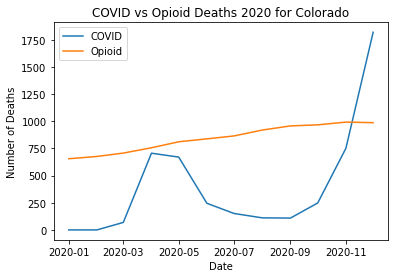

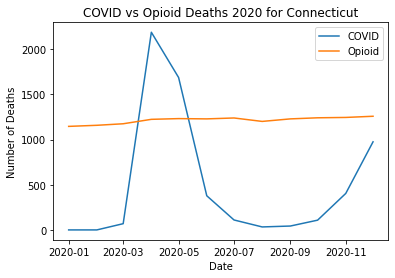

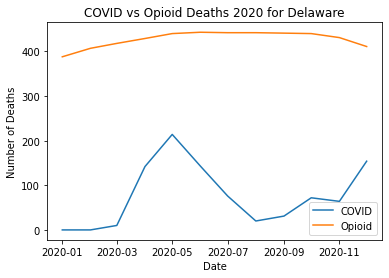

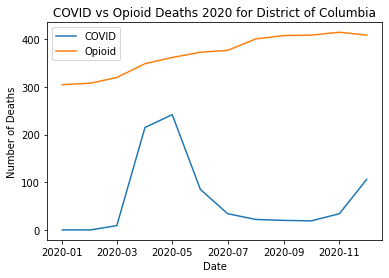

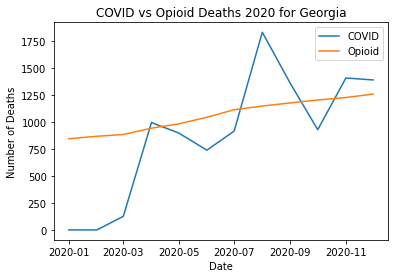

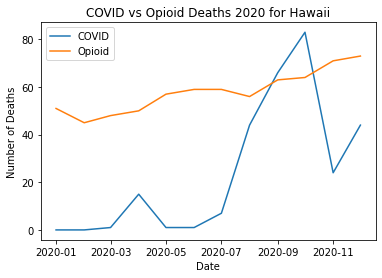

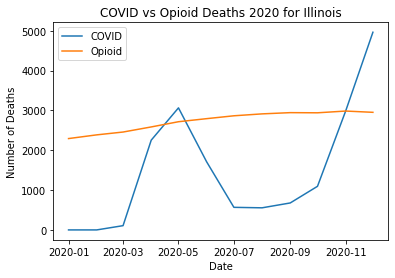

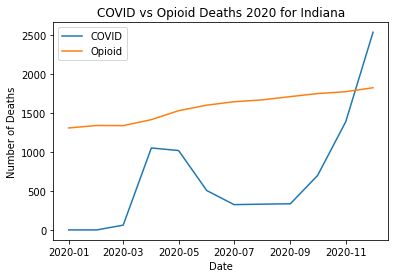

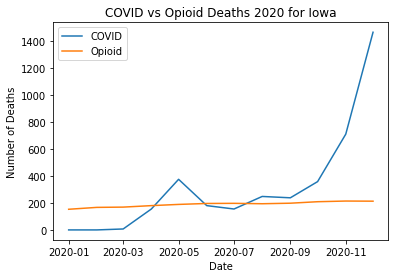

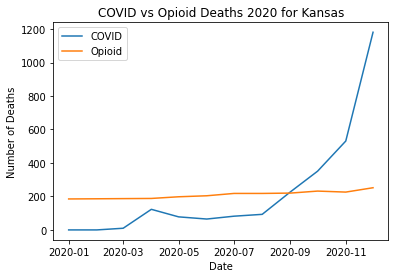

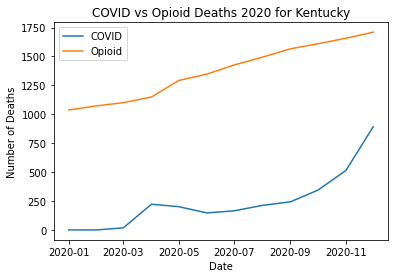

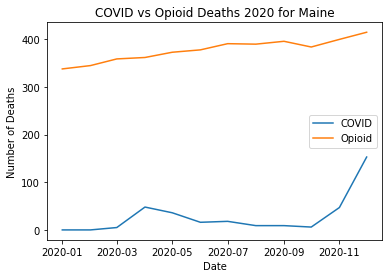

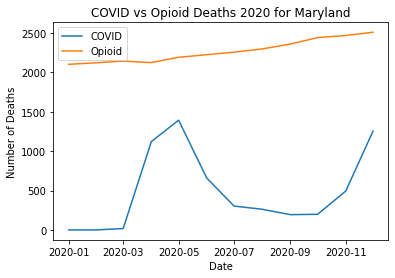

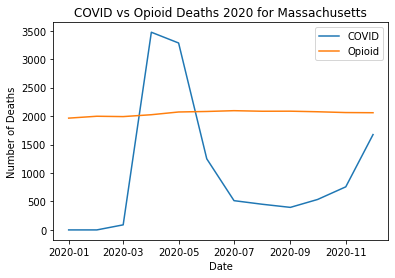

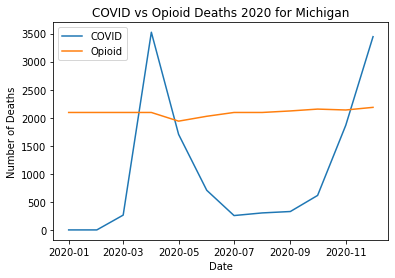

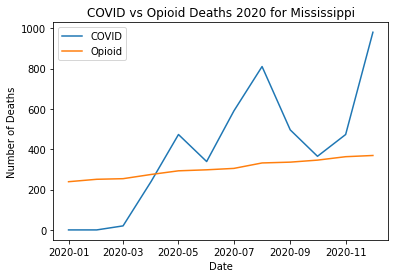

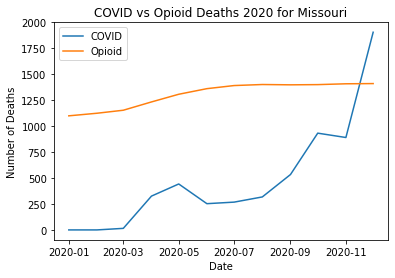

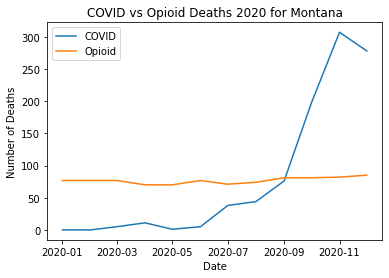

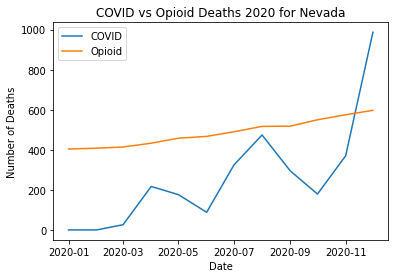

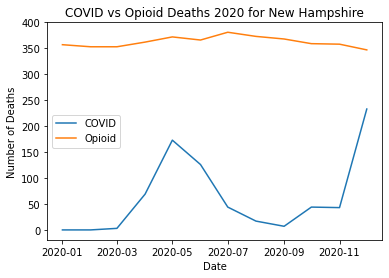

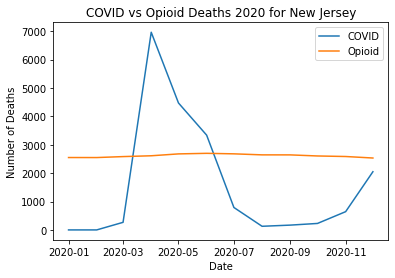

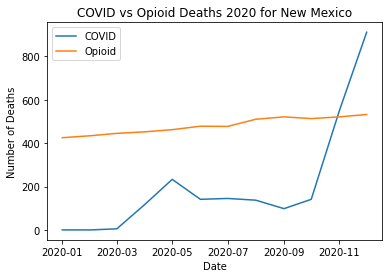

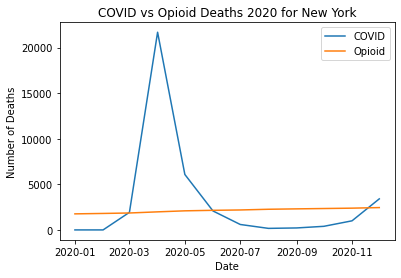

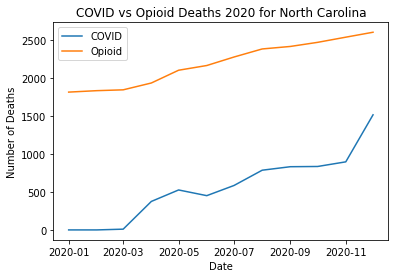

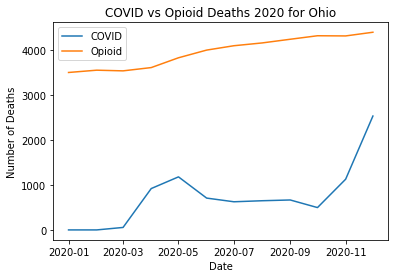

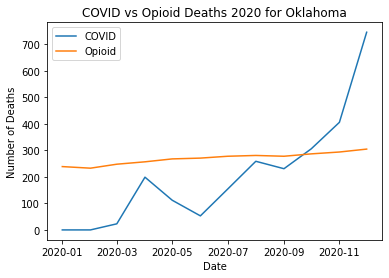

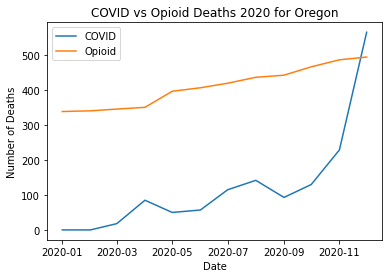

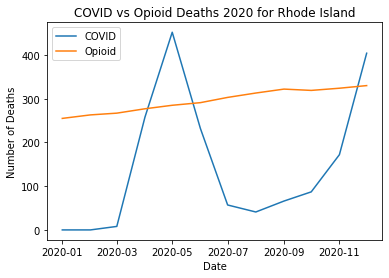

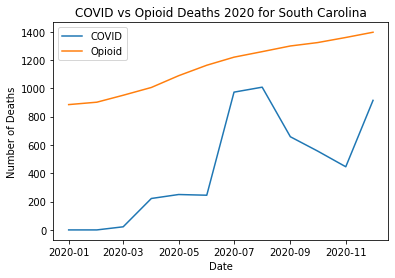

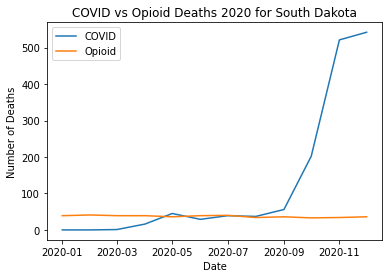

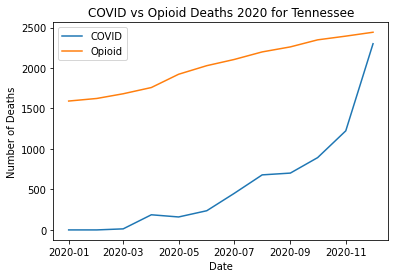

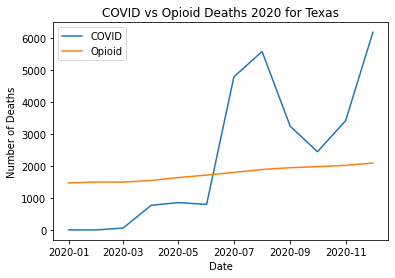

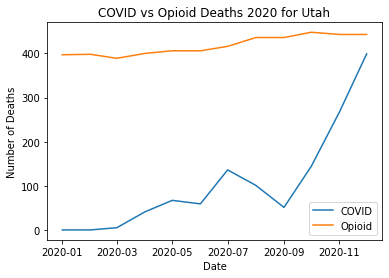

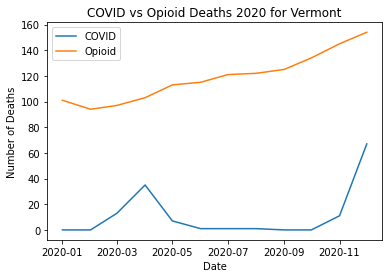

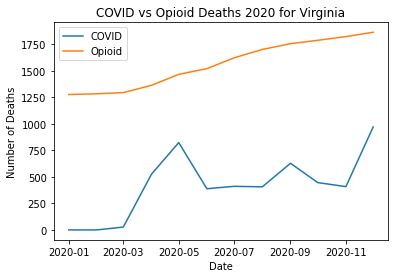

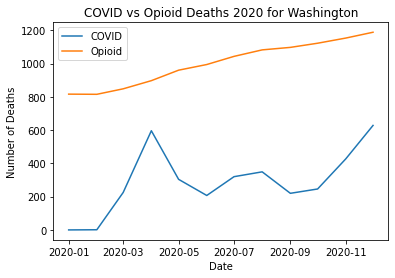

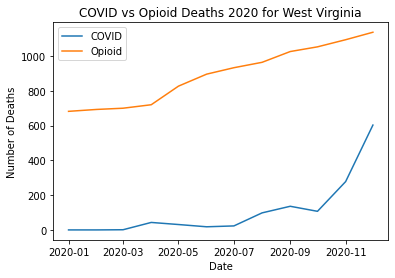

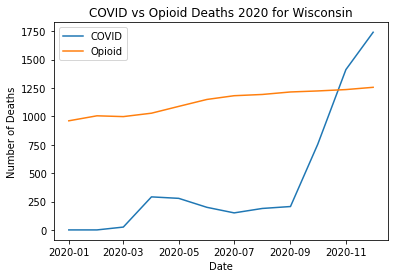

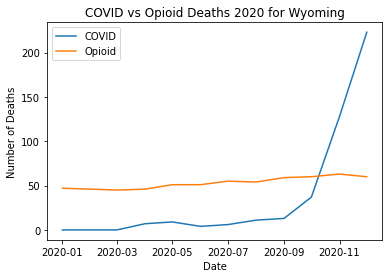

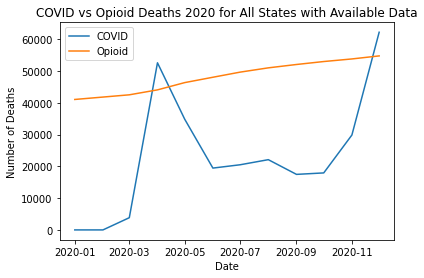

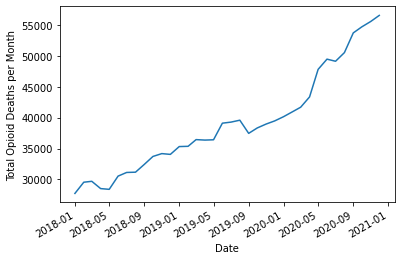

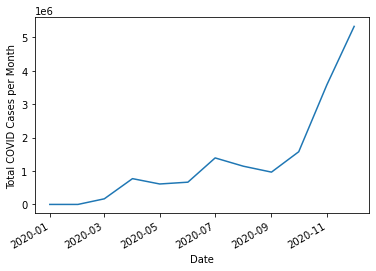

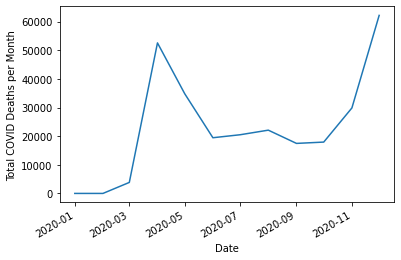

In [18]:
# # time plot for deaths for opioid over time for some states
for i, state in enumerate(stateswithavailabledata):
    covidopioidplot2020(state)
        
# time plot for deaths for opioid over time for all states' data combined
covidopioidplot2020("All")

# opioid deaths over time
timeplot(df_18_20_Opioid['Date'], df_18_20_Opioid['Total Deaths per Month'], "Date", "Total Opioid Deaths per Month")

# COVID cases/deaths over time
xdata = dfCOVIDbyMonth.copy()
dfCOVIDbyMonth = dfCOVIDbyMonth.set_index('date')
timeplot(xdata['date'], dfCOVIDbyMonth['Total Monthly COVID Cases'], "Date", "Total COVID Cases per Month")
timeplot(xdata['date'], dfCOVIDbyMonth['Total Monthly COVID Deaths'], "Date", "Total COVID Deaths per Month")

**Regression Analysis Work:**

Each cell below depicts the results of a basic linear regression analysis. We analyzed COVID Deaths per Capita versus Opioid Deaths Per Capita, COVID Deaths vs Unemployment 2020, COVID Cases vs Unemployement 2020, and Opioid Deaths vs Unemployment. 

In [19]:
y, Xmat = dmatrices('df_analysis["COVID Deaths Per Capita"] ~ df_analysis["Opioid Deaths Per Capita"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr=sm.OLS(y, Xmat).fit()
slr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                      
==================================================================================================
Dep. Variable:     df_analysis["COVID Deaths Per Capita"]   R-squared:                       0.016
Model:                                                OLS   Adj. R-squared:                 -0.004
Method:                                     Least Squares   F-statistic:                    0.7886
Date:                                    Sat, 04 Dec 2021   Prob (F-statistic):              0.379
Time:                                            15:39:09   Log-Likelihood:                 321.65
No. Observations:                                      51   AIC:                            -639.3
Df Residuals:                                          49   BIC:                            -635.4
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.0009      0.000      7.289      0.000       0.001       0.001
df_analysis["Opioid Deaths Per Capita"]     0.0405      0.046      0.888      0.379      -0.051       0.132
==============================================================================
Omnibus:                        1.317   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.518   Jarque-Bera (JB):                1.337
Skew:                           0.327   Prob(JB):                        0.513
Kurtosis:                       2.551   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
y2, Xmat2 = dmatrices('df_analysis["COVID Deaths"] ~ df_analysis["Unemployment_rate_2020"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr2=sm.OLS(y2, Xmat2).fit()
slr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     df_analysis["COVID Deaths"]   R-squared:                       0.184
Model:                                     OLS   Adj. R-squared:                  0.167
Method:                          Least Squares   F-statistic:                     11.03
Date:                         Sat, 04 Dec 2021   Prob (F-statistic):            0.00170
Time:                                 15:39:10   Log-Likelihood:                -524.73
No. Observations:                           51   AIC:                             1053.
Df Residuals:                               49   BIC:                             1057.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -7245.8017   4336.296     -1.671      0.101    -1.6e+04    1468.311
df_analysis["Unemployment_rate_2020"]  1899.7735    572.090      3.321      0.002     750.116    3049.431
==============================================================================
Omnibus:                       22.258   Durbin-Watson:                   2.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.882
Skew:                           1.338   Prob(JB):                     3.60e-09
Kurtosis:                       6.338   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
y3, Xmat3 = dmatrices('df_analysis["COVID Cases"] ~ df_analysis["Unemployment_rate_2020"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr3=sm.OLS(y3, Xmat3).fit()
slr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     df_analysis["COVID Cases"]   R-squared:                       0.088
Model:                                    OLS   Adj. R-squared:                  0.070
Method:                         Least Squares   F-statistic:                     4.739
Date:                        Sat, 04 Dec 2021   Prob (F-statistic):             0.0343
Time:                                15:39:10   Log-Likelihood:                -731.65
No. Observations:                          51   AIC:                             1467.
Df Residuals:                              49   BIC:                             1471.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                             -1.403e+05   2.51e+05     -0.559      0.578   -6.44e+05    3.64e+05
df_analysis["Unemployment_rate_2020"]    7.2e+04   3.31e+04      2.177      0.034    5531.965    1.38e+05
==============================================================================
Omnibus:                       39.642   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.569
Skew:                           2.150   Prob(JB):                     4.00e-27
Kurtosis:                       9.222   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
y4, Xmat4 = dmatrices('df_analysis["COVID Cases Per Capita"] ~ df_analysis["Opioid Deaths Per Capita"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr3=sm.OLS(y4, Xmat4).fit()
slr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     df_analysis["COVID Cases Per Capita"]   R-squared:                       0.100
Model:                                               OLS   Adj. R-squared:                  0.081
Method:                                    Least Squares   F-statistic:                     5.426
Date:                                   Sat, 04 Dec 2021   Prob (F-statistic):             0.0240
Time:                                           15:39:10   Log-Likelihood:                 126.68
No. Observations:                                     51   AIC:                            -249.4
Df Residuals:                                         49   BIC:                            -245.5
Df Model:                                              1                                         
Covariance Type:                               nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.0737      0.006     13.043      0.000       0.062       0.085
df_analysis["Opioid Deaths Per Capita"]    -4.8634      2.088     -2.329      0.024      -9.059      -0.668
==============================================================================
Omnibus:                        6.927   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                6.383
Skew:                          -0.604   Prob(JB):                       0.0411
Kurtosis:                       4.244   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
y5, Xmat5 = dmatrices('df_analysis["Opioid Deaths Per Capita"] ~ df_analysis["Unemployment_rate_2020"] ', data=df_analysis, return_type='dataframe')
# print(Xmat.head())
slr3=sm.OLS(y5, Xmat5).fit()
slr3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     df_analysis["Opioid Deaths Per Capita"]   R-squared:                       0.059
Model:                                                 OLS   Adj. R-squared:                  0.040
Method:                                      Least Squares   F-statistic:                     3.086
Date:                                     Sat, 04 Dec 2021   Prob (F-statistic):             0.0852
Time:                                             15:39:10   Log-Likelihood:                 265.02
No. Observations:                                       51   AIC:                            -526.0
Df Residuals:                                           49   BIC:                            -522.2
Df Model:                                                1                                         
Covariance Type:                                 nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                 0.0009      0.001      1.143      0.259      -0.001       0.003
df_analysis["Unemployment_rate_2020"]     0.0002      0.000      1.757      0.085   -2.73e-05       0.000
==============================================================================
Omnibus:                        7.833   Durbin-Watson:                   1.534
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                6.909
Skew:                           0.837   Prob(JB):                       0.0316
Kurtosis:                       3.668   Cond. No.                         32.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Final Scatterplots for Analysis:**
Below are the scatterplots that we chose to look at based on our above linear regression analysis. We decided to forgo plotting the race data since we found that this factor likely does not influence our final findings and initial problem that we were trying to examine. Unemployment data helps us to understand how each of these crisises impacts socioeconomic status 

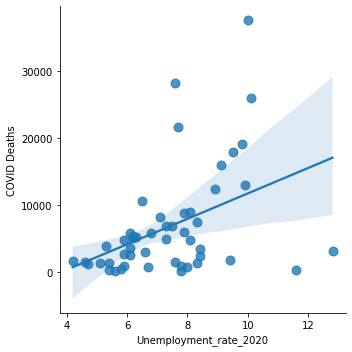

In [24]:
sns.lmplot(x="Unemployment_rate_2020", y="COVID Deaths", data=df_analysis,
           order=1, scatter_kws={"s": 80});

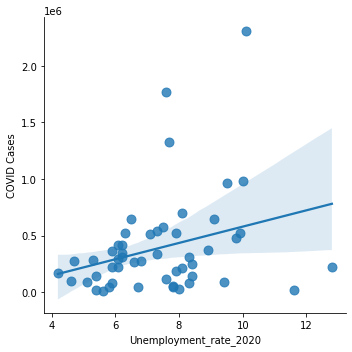

In [25]:
# df_analysis.head()
sns.lmplot(x="Unemployment_rate_2020", y="COVID Cases", data=df_analysis,
           order=0, scatter_kws={"s": 80});

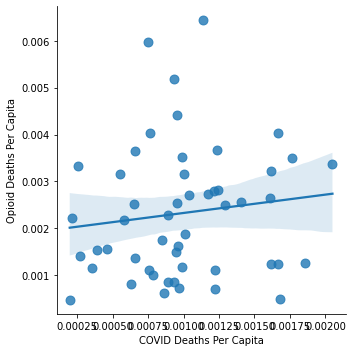

In [26]:
sns.lmplot(x= "COVID Deaths Per Capita", y="Opioid Deaths Per Capita", data=df_analysis,
           order=1, scatter_kws={"s": 80});

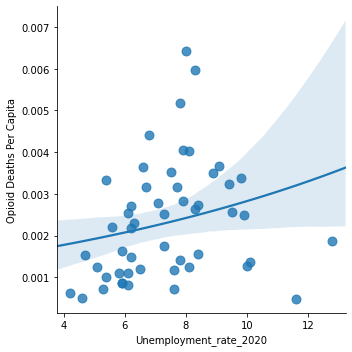

In [27]:
h = sns.lmplot(x= "Unemployment_rate_2020", y="Opioid Deaths Per Capita", data=df_analysis,
           order=-1, logistic=True, truncate=False, scatter_kws={"s": 80});
# h.set(xlim=(0, 1), ylim=(-.05, 1.05))

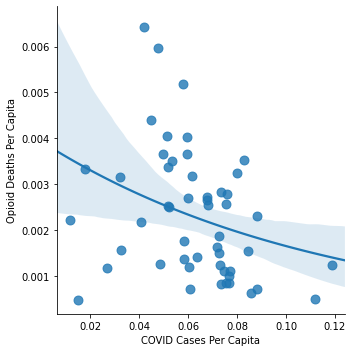

In [32]:
h = sns.lmplot(x= "COVID Cases Per Capita", y="Opioid Deaths Per Capita", data=df_analysis,
           order=-1, logistic=True, truncate=False, scatter_kws={"s": 80});

In [28]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout

def normalize_df(df):
    scaler = MinMaxScaler()
    scaler.fit(df)
    scaled = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled, columns=df.columns)
    return scaled_df

def deepNNmodel(column):
    df_analysis_1 = df_analysis.drop([column],axis=1)

    X = normalize_df(df_analysis_1) 
    y = normalize_df(pd.DataFrame(df_analysis[column])) 
    
    # split into train and test data
    # 80/20 split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

    model = Sequential()
    model.add(Dense(17, input_dim=17, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(9, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=1000, batch_size=3)

    pred_train= model.predict(X_train)
    print(metrics.mean_squared_error(y_train,pred_train))

    pred= model.predict(X_test)
    print(metrics.mean_squared_error(y_test,pred))

In [29]:
deepNNmodel('Opioid Deaths')

Epoch 1/1000
14/14 [==============================] - 1s 3ms/step - loss: 0.1337 - accuracy: 0.0250 
Epoch 2/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.1410 - accuracy: 0.0500
Epoch 3/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.1429 - accuracy: 0.0000e+00
Epoch 4/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1333 - accuracy: 0.0250
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1044 - accuracy: 0.0500
Epoch 6/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.1135 - accuracy: 0.0500
Epoch 7/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.1115 - accuracy: 0.0250
Epoch 8/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.1009 - accuracy: 0.0500
Epoch 9/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0974 - accuracy: 0.0500
Epoch 10/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0944 - accuracy: 0

14/14 [==============================] - 0s 4ms/step - loss: 0.0370 - accuracy: 0.0250
Epoch 83/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0316 - accuracy: 0.0250
Epoch 84/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0288 - accuracy: 0.0500
Epoch 85/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0274 - accuracy: 0.0250
Epoch 86/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0340 - accuracy: 0.0250
Epoch 87/1000
14/14 [==============================] - 0s 5ms/step - loss: 0.0257 - accuracy: 0.0250
Epoch 88/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0223 - accuracy: 0.0250
Epoch 89/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0312 - accuracy: 0.0500
Epoch 90/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0387 - accuracy: 0.0250
Epoch 91/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0406 - accuracy: 0.0250
Epoc

14/14 [==============================] - 0s 4ms/step - loss: 0.0254 - accuracy: 0.0500
Epoch 243/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0381 - accuracy: 0.0250
Epoch 244/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0398 - accuracy: 0.0250
Epoch 245/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0452 - accuracy: 0.0250
Epoch 246/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0272 - accuracy: 0.0250
Epoch 247/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0196 - accuracy: 0.0500
Epoch 248/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0386 - accuracy: 0.0250
Epoch 249/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0383 - accuracy: 0.0250
Epoch 250/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0460 - accuracy: 0.0250
Epoch 251/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0262 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.0500
Epoch 403/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0212 - accuracy: 0.0500
Epoch 404/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0223 - accuracy: 0.0500
Epoch 405/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 0.0500
Epoch 406/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.0250
Epoch 407/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0116 - accuracy: 0.0500
Epoch 408/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 0.0500
Epoch 409/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0241 - accuracy: 0.0250
Epoch 410/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0142 - accuracy: 0.0500
Epoch 411/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0170 - accuracy: 0.0500
Epoch 563/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.0500
Epoch 564/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0217 - accuracy: 0.0250
Epoch 565/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0215 - accuracy: 0.0500
Epoch 566/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0149 - accuracy: 0.0500
Epoch 567/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.0500
Epoch 568/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0322 - accuracy: 0.0250
Epoch 569/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0263 - accuracy: 0.0500
Epoch 570/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.0500
Epoch 571/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0124 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0155 - accuracy: 0.0500
Epoch 723/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.0500
Epoch 724/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.0500
Epoch 725/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0351 - accuracy: 0.0250    
Epoch 726/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0147 - accuracy: 0.0500
Epoch 727/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.0500
Epoch 728/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.0500
Epoch 729/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0136 - accuracy: 0.0500
Epoch 730/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.0500    
Epoch 731/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0140 - accu

14/14 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.0500
Epoch 883/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 0.0500
Epoch 884/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.0500
Epoch 885/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0108 - accuracy: 0.0500
Epoch 886/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.0500
Epoch 887/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.0500
Epoch 888/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0127 - accuracy: 0.0500
Epoch 889/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0252 - accuracy: 0.0250
Epoch 890/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0091 - accuracy: 0.0500
Epoch 891/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.

In [30]:
deepNNmodel('COVID Cases')

Epoch 1/1000
14/14 [==============================] - 1s 3ms/step - loss: 0.1558 - accuracy: 0.0250
Epoch 2/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1733 - accuracy: 0.0250
Epoch 3/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.1440 - accuracy: 0.0250
Epoch 4/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.1346 - accuracy: 0.0250
Epoch 5/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1423 - accuracy: 0.0000e+00
Epoch 6/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1402 - accuracy: 0.0250
Epoch 7/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1297 - accuracy: 0.0250
Epoch 8/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1165 - accuracy: 0.0250
Epoch 9/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1120 - accuracy: 0.0000e+00
Epoch 10/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.1091 - accuracy

14/14 [==============================] - 0s 2ms/step - loss: 0.0164 - accuracy: 0.0250
Epoch 83/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.0250
Epoch 84/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0213 - accuracy: 0.0250
Epoch 85/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0120 - accuracy: 0.0250
Epoch 86/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0162 - accuracy: 0.0250
Epoch 87/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0144 - accuracy: 0.0250
Epoch 88/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0117 - accuracy: 0.0250
Epoch 89/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0168 - accuracy: 0.0250
Epoch 90/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0118 - accuracy: 0.0250
Epoch 91/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0167 - accuracy: 0.0250
Epoc

14/14 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.0250
Epoch 243/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.0250
Epoch 244/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0103 - accuracy: 0.0250
Epoch 245/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0131 - accuracy: 0.0250
Epoch 246/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.0250
Epoch 247/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0088 - accuracy: 0.0250
Epoch 248/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.0250
Epoch 249/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 0.0250
Epoch 250/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0159 - accuracy: 0.0250
Epoch 251/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0065 - accuracy: 0.0250
Epoch 403/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.0250
Epoch 404/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0141 - accuracy: 0.0250
Epoch 405/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0100 - accuracy: 0.0250
Epoch 406/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0087 - accuracy: 0.0250
Epoch 407/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.0250
Epoch 408/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0110 - accuracy: 0.0250
Epoch 409/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0102 - accuracy: 0.0250
Epoch 410/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0095 - accuracy: 0.0250
Epoch 411/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0109 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.0250
Epoch 563/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0157 - accuracy: 0.0250
Epoch 564/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0133 - accuracy: 0.0250
Epoch 565/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.0250    
Epoch 566/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 0.0250
Epoch 567/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.0250
Epoch 568/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.0250
Epoch 569/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.0250
Epoch 570/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.0250
Epoch 571/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy

14/14 [==============================] - 0s 2ms/step - loss: 0.0036 - accuracy: 0.0250
Epoch 722/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.0250
Epoch 723/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 0.0250
Epoch 724/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 0.0250
Epoch 725/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0067 - accuracy: 0.0250
Epoch 726/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.0250
Epoch 727/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.0250    
Epoch 728/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.0250
Epoch 729/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.0250
Epoch 730/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0097 - accuracy

14/14 [==============================] - 0s 2ms/step - loss: 0.0037 - accuracy: 0.0250
Epoch 882/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0138 - accuracy: 0.0250
Epoch 883/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0123 - accuracy: 0.0250
Epoch 884/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.0250
Epoch 885/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.0250
Epoch 886/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.0250
Epoch 887/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0135 - accuracy: 0.0250
Epoch 888/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0050 - accuracy: 0.0250
Epoch 889/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0085 - accuracy: 0.0250
Epoch 890/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0067 - accuracy: 0.

In [31]:
deepNNmodel('COVID Deaths')

Epoch 1/1000
14/14 [==============================] - 1s 2ms/step - loss: 0.2002 - accuracy: 0.0000e+00
Epoch 2/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.2016 - accuracy: 0.0000e+00
Epoch 3/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.0000e+00
Epoch 4/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.0000e+00
Epoch 5/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.0250
Epoch 6/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1430 - accuracy: 0.0000e+00
Epoch 7/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1404 - accuracy: 0.0000e+00
Epoch 8/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1164 - accuracy: 0.0000e+00
Epoch 9/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.1374 - accuracy: 0.0000e+00
Epoch 10/1000
14/14 [==============================] - 0s 2ms/step -

14/14 [==============================] - 0s 2ms/step - loss: 0.0206 - accuracy: 0.0250
Epoch 162/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0301 - accuracy: 0.0250
Epoch 163/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0128 - accuracy: 0.0500
Epoch 164/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0200 - accuracy: 0.0500
Epoch 165/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0184 - accuracy: 0.0500
Epoch 166/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0369 - accuracy: 0.0250
Epoch 167/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0170 - accuracy: 0.0250
Epoch 168/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.0250
Epoch 169/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0083 - accuracy: 0.0500
Epoch 170/1000
14/14 [==============================] - 0s 4ms/step - loss: 0.0189 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0104 - accuracy: 0.0500
Epoch 322/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0248 - accuracy: 0.0500
Epoch 323/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0193 - accuracy: 0.0500
Epoch 324/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 0.0500
Epoch 325/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.0500
Epoch 326/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0335 - accuracy: 0.0250
Epoch 327/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.0500
Epoch 328/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0173 - accuracy: 0.0500
Epoch 329/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0138 - accuracy: 0.0500
Epoch 330/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0137 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0158 - accuracy: 0.0250
Epoch 482/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.0500
Epoch 483/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0071 - accuracy: 0.0500
Epoch 484/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.0500
Epoch 485/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0146 - accuracy: 0.0500
Epoch 486/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.0500
Epoch 487/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0156 - accuracy: 0.0500
Epoch 488/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0299 - accuracy: 0.0250    
Epoch 489/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0079 - accuracy: 0.0500    
Epoch 490/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0143 - accu

14/14 [==============================] - 0s 2ms/step - loss: 0.0120 - accuracy: 0.0500
Epoch 642/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0175 - accuracy: 0.0500
Epoch 643/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0068 - accuracy: 0.0500
Epoch 644/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0179 - accuracy: 0.0500
Epoch 645/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0148 - accuracy: 0.0500
Epoch 646/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 0.0500
Epoch 647/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0111 - accuracy: 0.0500
Epoch 648/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.0500
Epoch 649/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0113 - accuracy: 0.0500
Epoch 650/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0233 - accuracy: 0.

14/14 [==============================] - 0s 2ms/step - loss: 0.0075 - accuracy: 0.0500
Epoch 802/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0199 - accuracy: 0.0250
Epoch 803/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0085 - accuracy: 0.0500
Epoch 804/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0053 - accuracy: 0.0500    
Epoch 805/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0090 - accuracy: 0.0500
Epoch 806/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0144 - accuracy: 0.0500
Epoch 807/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0089 - accuracy: 0.0500
Epoch 808/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.0500
Epoch 809/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0245 - accuracy: 0.0250
Epoch 810/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0174 - accuracy

14/14 [==============================] - 0s 2ms/step - loss: 0.0092 - accuracy: 0.0500
Epoch 962/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 0.0500
Epoch 963/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.0500
Epoch 964/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0101 - accuracy: 0.0500
Epoch 965/1000
14/14 [==============================] - 0s 3ms/step - loss: 0.0072 - accuracy: 0.0500
Epoch 966/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 0.0500
Epoch 967/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0162 - accuracy: 0.0500
Epoch 968/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0076 - accuracy: 0.0500
Epoch 969/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 0.0500
Epoch 970/1000
14/14 [==============================] - 0s 2ms/step - loss: 0.0044 - accuracy: 0.